#Previsão de Vendas

<p>Instituto Mauá de Tecnologia</p>
<p>Aluno: Gabriel de Souza Lima <p/>
<p>RA: 20.84031-4<p/>
<p>Professor: Tiago Sanches</p>

## Objetivo

<p>Este Trabalho tem como Objetivo prever o Faturamento de um determinado varejista a partir de dados históricos do mesmo.</p>

<p>Para tal ação será utilizado o seguinte dataset:</p>
<a href='https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data'> Dataset do Kaggle <a/>

## Importação de Bibliotecas 

<p>Para iniciarmos, vamos importar as bibliotecas necessárias</p>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import missingno as msno

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Montagem do Drive e verificação de diretório

<p>Para importação da Tabela precisamos montar o Drive...</p>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls

drive  sample_data


## Manipulando os Dados

<p>Após a montagem do drive, estamos aptos para importar a tabela e tratar os Dados<p/>

### Importando a Tabela

<p>Utilizaremos a biblioteca Pandas para realizar a importação, para isso precisamos apenas passar o caminho onde a tabela se encontra.</p>

In [5]:
sales= pd.read_csv('drive/My Drive/Dell_Windows/Lstm/future_sales/sales_train.csv')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Entendendo os Dados

<p>Precisamos então entender oque diz cada coluna , uma vez que nossa tabela já esta importada.</p>
<p>Para isso vamos imprimir o nome de cada coluna...</p>


In [6]:
print(sales.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


<p>No Kaggle (site fonte dos dados) há a identifcação de cada coluna, são elas:</p>

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_price - current price of an item

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

### Convertendo Str para Data

<p>O primeiro tratamento nos dados será a conversão da data que se encontra como uma string.</p>

In [7]:
sales['date']= pd.to_datetime(sales['date'],format = '%d.%m.%Y')
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


### Ordenando por Data

<p> E então ordenando ...</p>

In [8]:
sales.sort_values(by='date',inplace=True)
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
49800,2013-01-01,0,18,5823,2500.0,1.0
29784,2013-01-01,0,27,5573,849.0,1.0
35476,2013-01-01,0,7,1006,399.0,1.0
8330,2013-01-01,0,19,17707,899.0,1.0
57384,2013-01-01,0,14,19548,149.0,1.0
...,...,...,...,...,...,...
2885098,2015-10-31,33,41,21386,169.0,1.0
2930981,2015-10-31,33,21,988,199.0,1.0
2885097,2015-10-31,33,41,21377,169.0,1.0
2930993,2015-10-31,33,22,10207,1199.0,1.0


### Conferindo Integridade dos Dados

<p>Neste ponto conferimos então a integridade dos Dados, garantindo assim que não há campos faltantes....</p>

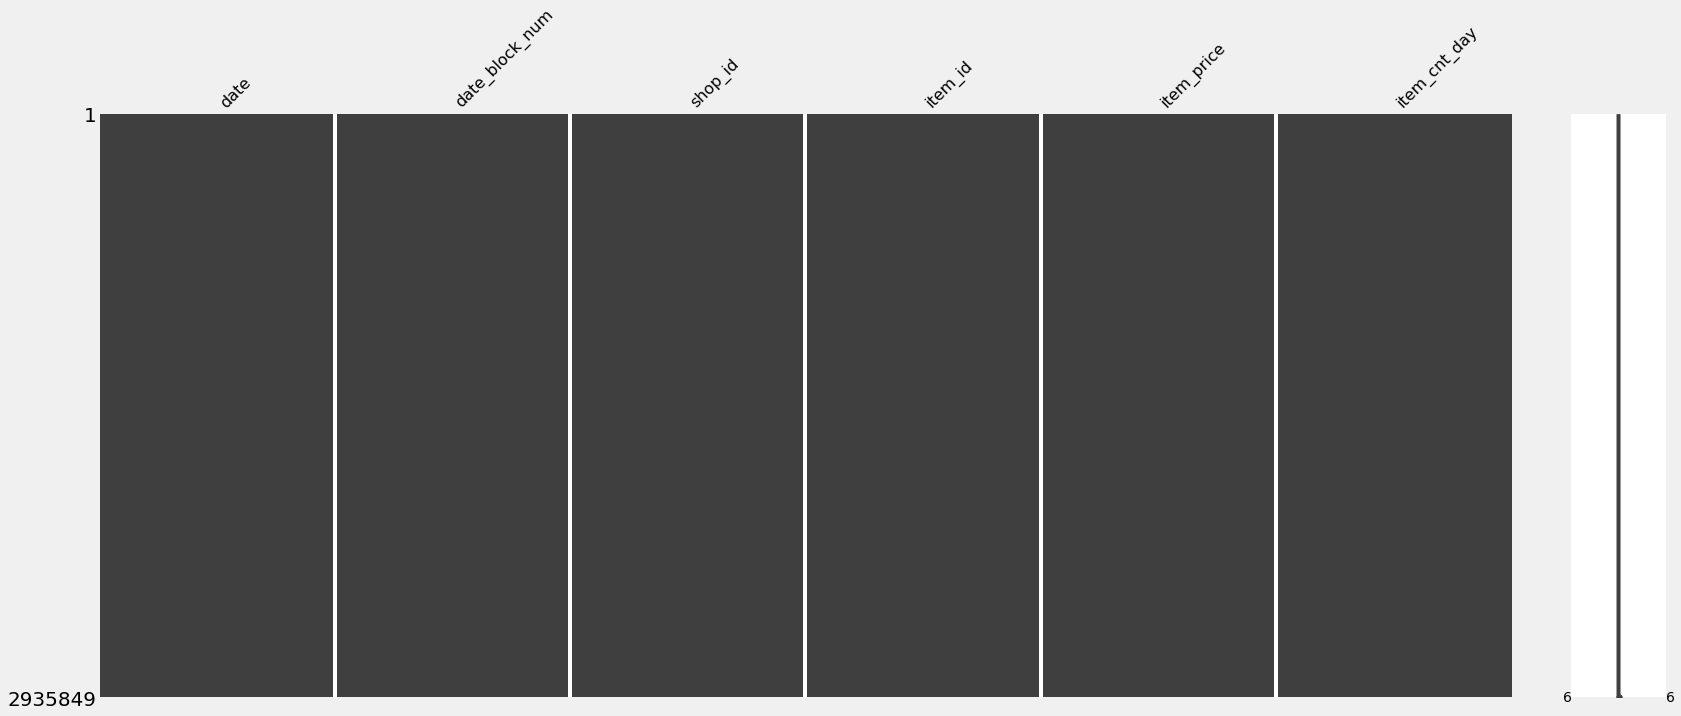

In [9]:
msno.matrix(sales)

<p>E plotamos também um grafico de barras, para termos como informação o número de elementos... <p/>

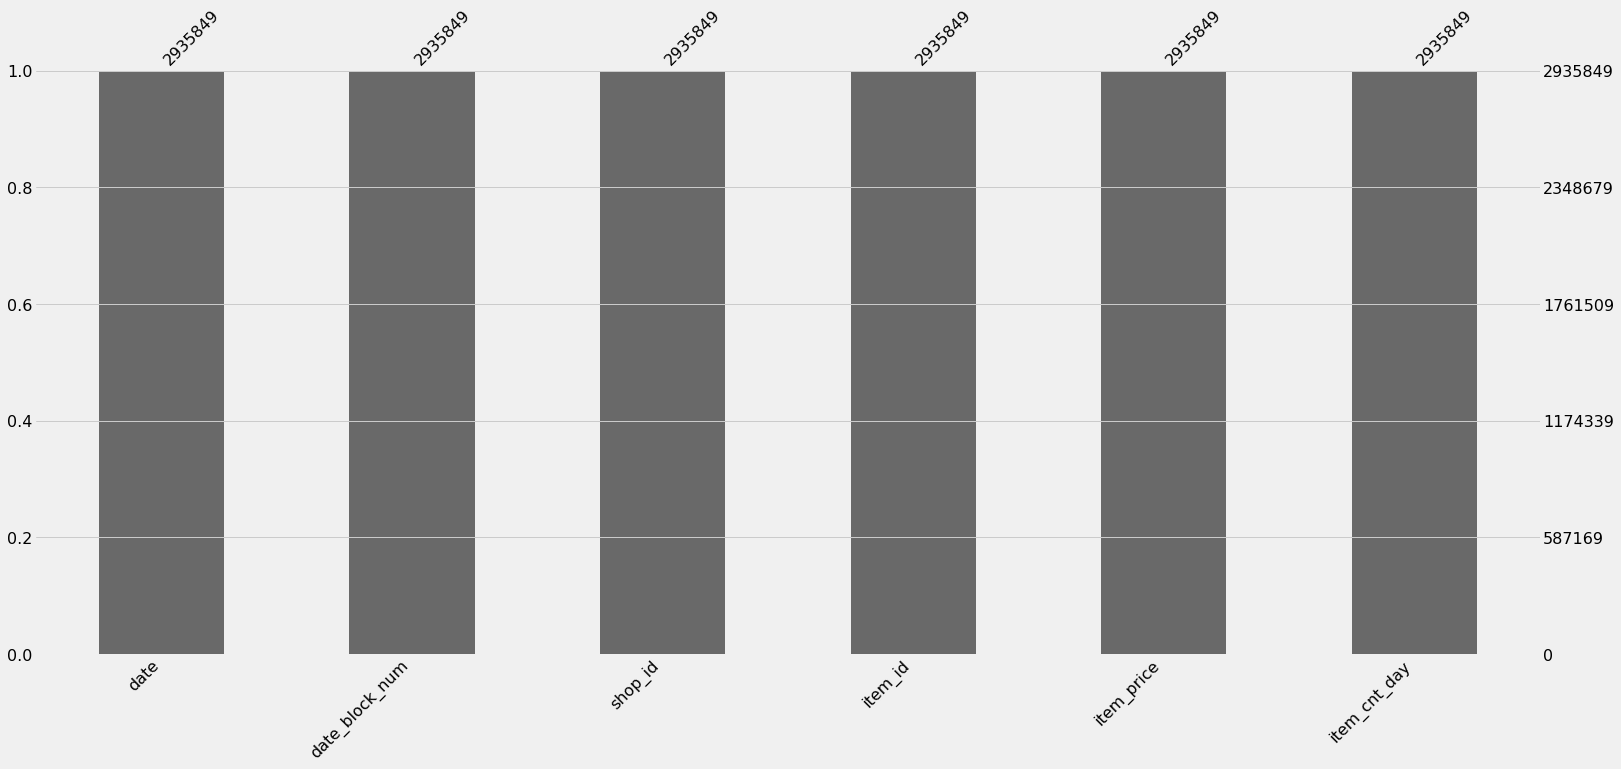

In [10]:
msno.bar(sales)

### Analisando as Colunas

<p>Vamos analisar cada coluna de nosso dataframe para podermos assim entender seus dados... </p>

In [11]:
shop_id_number = sales.iloc[:,1].unique()
print(np.sort(shop_id_number))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [12]:
item_price = sales.iloc[:,4].unique()
print(np.sort(item_price))

[-1.0000e+00  7.0000e-02  8.7500e-02 ...  5.0999e+04  5.9200e+04
  3.0798e+05]


In [13]:
item_id = sales.iloc[:,2].unique()
print(np.sort(item_id))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [14]:
item_count_day = sales.iloc[:,5].unique()
print(np.sort(item_count_day))

[-2.200e+01 -1.600e+01 -9.000e+00 -6.000e+00 -5.000e+00 -4.000e+00
 -3.000e+00 -2.000e+00 -1.000e+00  1.000e+00  2.000e+00  3.000e+00
  4.000e+00  5.000e+00  6.000e+00  7.000e+00  8.000e+00  9.000e+00
  1.000e+01  1.100e+01  1.200e+01  1.300e+01  1.400e+01  1.500e+01
  1.600e+01  1.700e+01  1.800e+01  1.900e+01  2.000e+01  2.100e+01
  2.200e+01  2.300e+01  2.400e+01  2.500e+01  2.600e+01  2.700e+01
  2.800e+01  2.900e+01  3.000e+01  3.100e+01  3.200e+01  3.300e+01
  3.400e+01  3.500e+01  3.600e+01  3.700e+01  3.800e+01  3.900e+01
  4.000e+01  4.100e+01  4.200e+01  4.300e+01  4.400e+01  4.500e+01
  4.600e+01  4.700e+01  4.800e+01  4.900e+01  5.000e+01  5.100e+01
  5.200e+01  5.300e+01  5.400e+01  5.500e+01  5.600e+01  5.700e+01
  5.800e+01  5.900e+01  6.000e+01  6.100e+01  6.200e+01  6.300e+01
  6.400e+01  6.500e+01  6.600e+01  6.700e+01  6.800e+01  6.900e+01
  7.000e+01  7.100e+01  7.200e+01  7.300e+01  7.400e+01  7.500e+01
  7.600e+01  7.700e+01  7.800e+01  7.900e+01  8.000e+01  8.100

### Demarcando as Inconsistencias

<p>Na seção anterior você pôde notar que duas colunas haviam itens negativos no qual não fazia sentido... Precisamos então demarcálas com NAN para posteriormente elimina-las.</p>

In [15]:
sales['item_price'] = np.where(sales.item_price < 0,float("NaN"),sales.item_price)

In [16]:
item_price = sales.iloc[:,4].unique()
print(np.sort(item_price))

[7.0000e-02 8.7500e-02 9.0000e-02 ... 5.9200e+04 3.0798e+05        nan]


In [17]:
sales['item_cnt_day'] = np.where(sales.item_cnt_day < 0,float("NaN"),sales.item_cnt_day)

In [18]:
item_count_day = sales.iloc[:,5].unique()
print(np.sort(item_count_day))

[1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 7.000e+00
 8.000e+00 9.000e+00 1.000e+01 1.100e+01 1.200e+01 1.300e+01 1.400e+01
 1.500e+01 1.600e+01 1.700e+01 1.800e+01 1.900e+01 2.000e+01 2.100e+01
 2.200e+01 2.300e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 2.800e+01
 2.900e+01 3.000e+01 3.100e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01
 3.600e+01 3.700e+01 3.800e+01 3.900e+01 4.000e+01 4.100e+01 4.200e+01
 4.300e+01 4.400e+01 4.500e+01 4.600e+01 4.700e+01 4.800e+01 4.900e+01
 5.000e+01 5.100e+01 5.200e+01 5.300e+01 5.400e+01 5.500e+01 5.600e+01
 5.700e+01 5.800e+01 5.900e+01 6.000e+01 6.100e+01 6.200e+01 6.300e+01
 6.400e+01 6.500e+01 6.600e+01 6.700e+01 6.800e+01 6.900e+01 7.000e+01
 7.100e+01 7.200e+01 7.300e+01 7.400e+01 7.500e+01 7.600e+01 7.700e+01
 7.800e+01 7.900e+01 8.000e+01 8.100e+01 8.200e+01 8.300e+01 8.400e+01
 8.500e+01 8.600e+01 8.700e+01 8.800e+01 8.900e+01 9.000e+01 9.100e+01
 9.200e+01 9.300e+01 9.500e+01 9.600e+01 9.700e+01 9.800e+01 9.900e+01
 1.000

###Conferindo Novamente Integridade dos Dados

<p>Após a demarcação das inconsistencias vamos então removêlas e analisar os dados Novamente.</p>

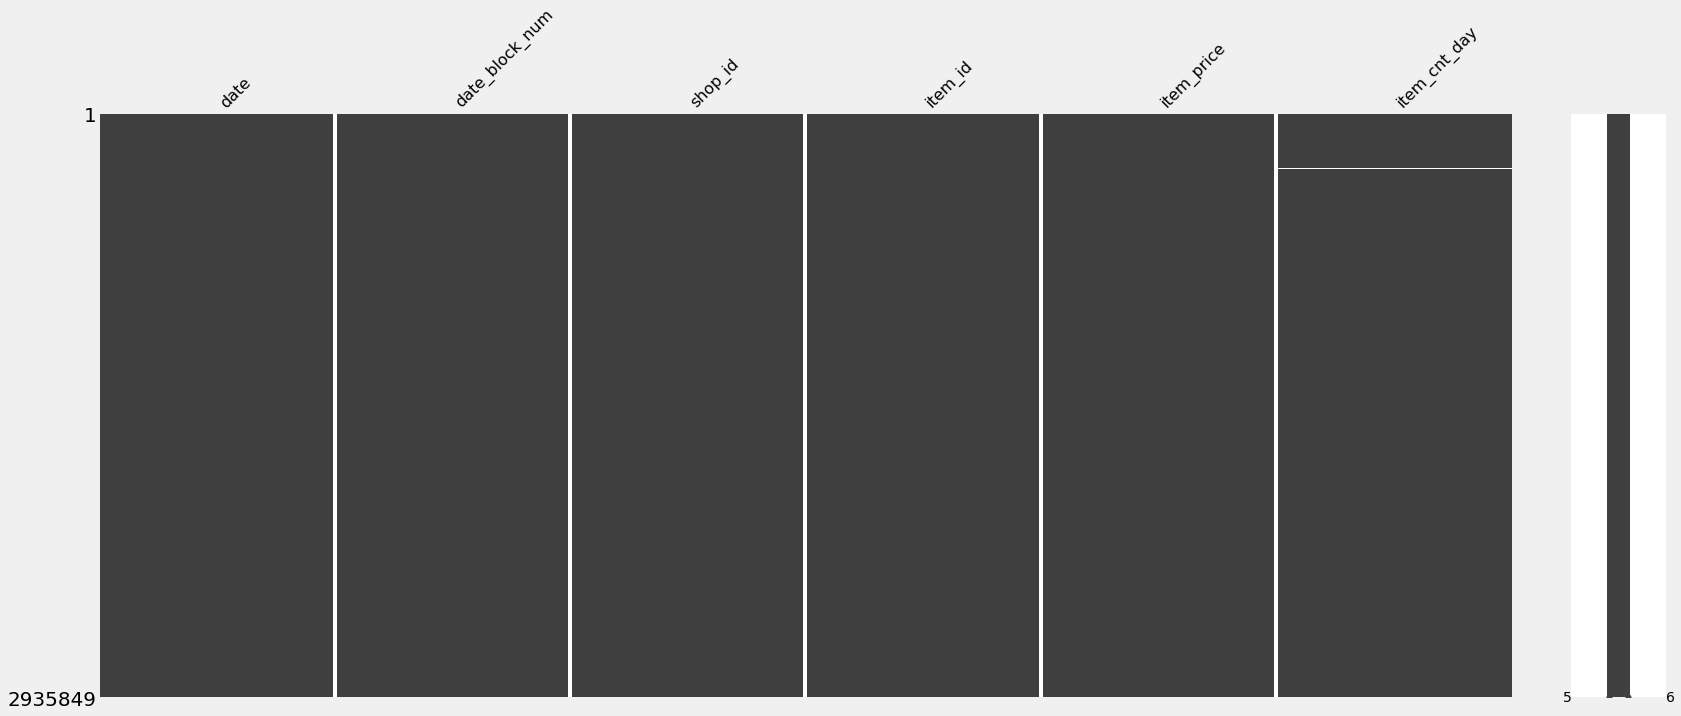

In [19]:
msno.matrix(sales)

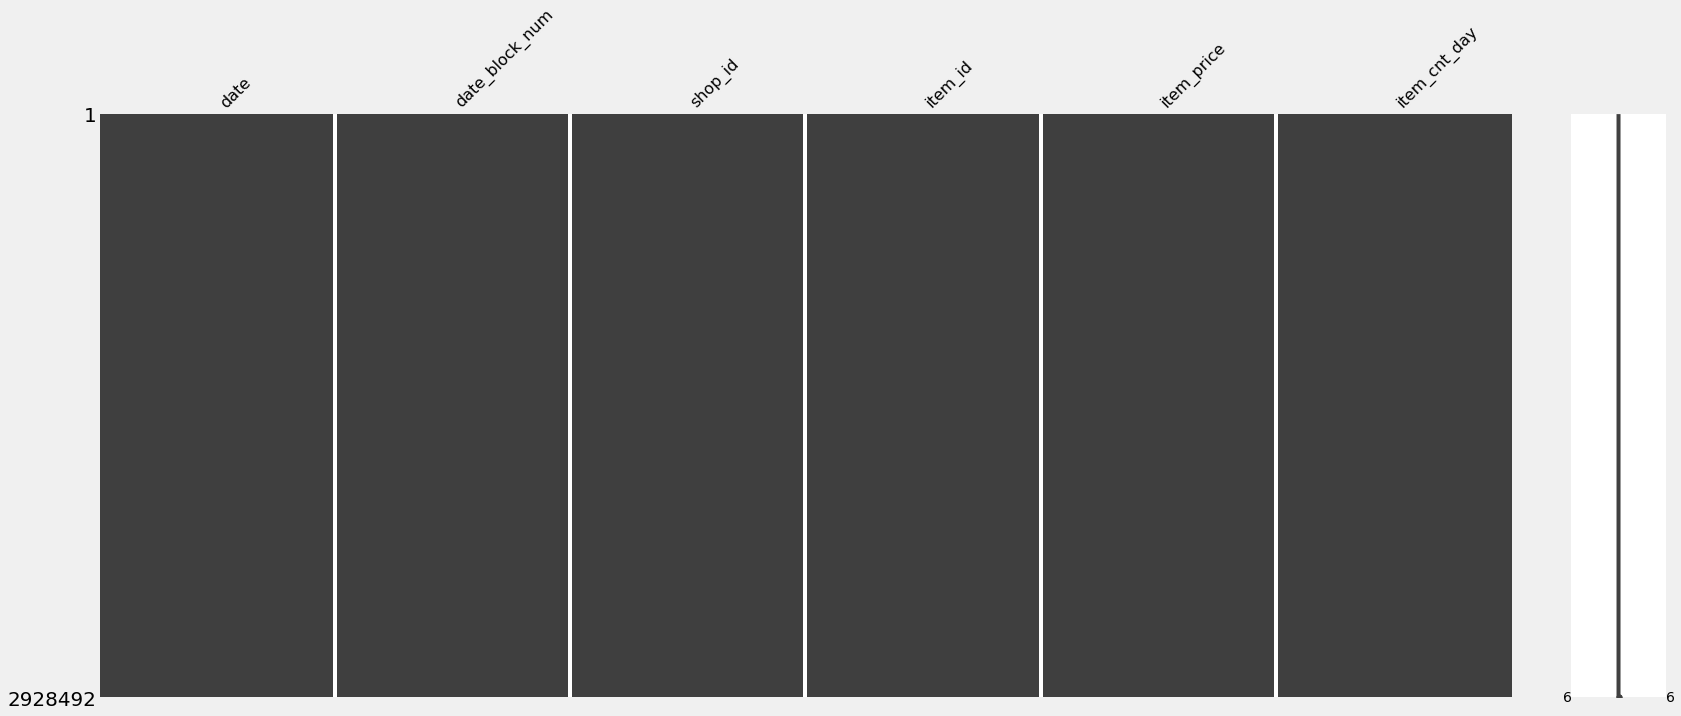

In [20]:
sales.dropna(inplace=True)
msno.matrix(sales)

### Calculando o Faturamento

<p>Precisamos então criar a segunda feature de entrada de nossa rede, visto que a primeira ja temos:</p>

In [21]:
revenue = {'revenue_per_sale':sales['item_cnt_day']*sales['item_price']}
revenue_per_sale = pd.DataFrame(data = revenue)
sales = pd.concat([sales,revenue_per_sale],axis=1,)
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue_per_sale
49800,2013-01-01,0,18,5823,2500.0,1.0,2500.0
29784,2013-01-01,0,27,5573,849.0,1.0,849.0
35476,2013-01-01,0,7,1006,399.0,1.0,399.0
8330,2013-01-01,0,19,17707,899.0,1.0,899.0
57384,2013-01-01,0,14,19548,149.0,1.0,149.0


### Calculando a quantia e o Montante vendido por Dia 

<p>Colocamos essas duas features de entrada da rede em um novo Dataframe para simplificar a manipulação posterior:</p>

In [22]:
sales_per_day = sales.groupby(by='date')[['item_cnt_day','revenue_per_sale']].sum()
sales_per_day

,item_cnt_day,revenue_per_sale
date,,
2013-01-01,1957.0,1371116.50
2013-01-02,8232.0,6070414.01
2013-01-03,7444.0,5460386.50
2013-01-04,6628.0,4769843.50
2013-01-05,6360.0,4600005.40
...,...,...
2015-10-27,1555.0,2266689.13
2015-10-28,3599.0,1726194.10
2015-10-29,1591.0,1860141.14


### Analisando Graficamente

<p>Vamos realizar uma analise grafica para melhor compreensão:<p>

Text(0, 0.5, 'item')

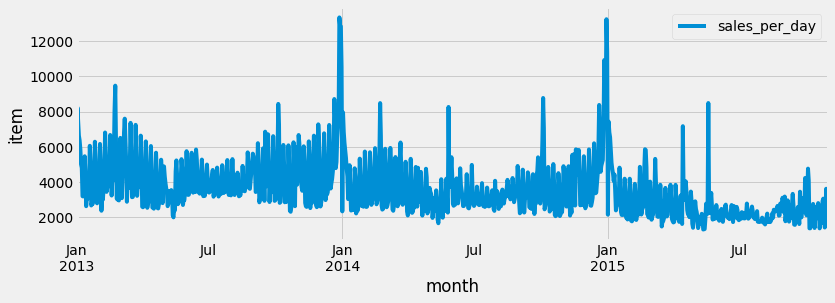

In [23]:
sales_per_day['item_cnt_day'].plot(figsize=(12,4),legend=True)
plt.legend(['sales_per_day'])
plt.xlabel('month')
plt.ylabel('item')

Text(0, 0.5, 'Daily Revenue')

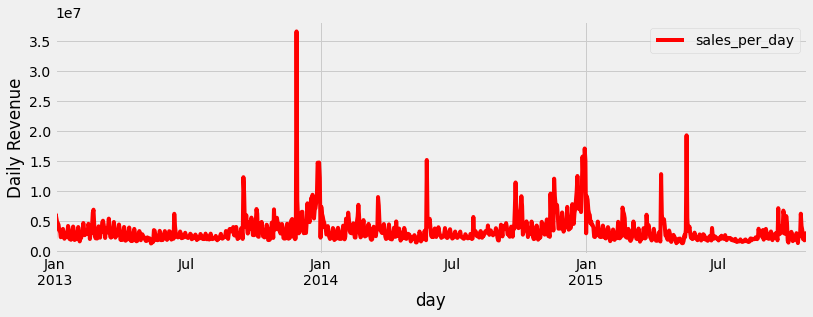

In [24]:
sales_per_day['revenue_per_sale'].plot(figsize=(12,4),legend=True,color='red')
plt.legend(['sales_per_day'])
plt.xlabel('day')
plt.ylabel('Daily Revenue')

### Divisão entre Teste e treino 

<p>O ultimo passo de Tratamento dos dados é a divisão entre teste e Treino.</p>
<p> Plotaremos esses dados novamente pois agora está explicito os dados que usaremos para treinar (AZUL) e testar(VERMELHO)...
<p>Como o dataset é pequeno, será usado apenas 10% dos dados para teste. </p>

In [25]:
item_per_day   = sales_per_day['item_cnt_day']
revenue_per_day = sales_per_day['revenue_per_sale']

In [26]:
item_per_day_train = item_per_day.iloc[:1010]
item_per_day_test  = item_per_day.iloc[1009:]
daily_revenue_train = revenue_per_day.iloc[:1010]
daily_revenue_test  = revenue_per_day.iloc[1009:]

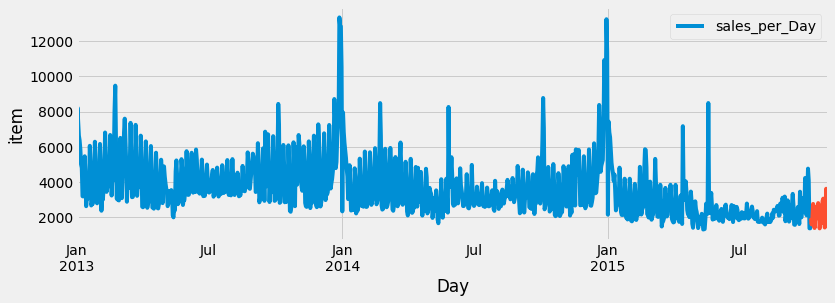

In [27]:
item_per_day_train.plot(label=True,figsize=(12,4))
item_per_day_test.plot(label =True,figsize=(12,4))
plt.legend(['sales_per_Day'])
plt.xlabel('Day')
plt.ylabel('item')
plt.show()

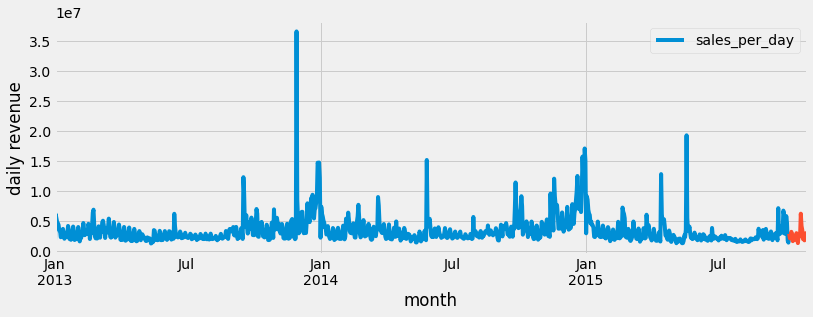

In [28]:
daily_revenue_train.plot(label=True,figsize=(12,4))
daily_revenue_test.plot(label =True,figsize=(12,4))
plt.legend(['sales_per_day'])
plt.xlabel('month')
plt.ylabel('daily revenue')
plt.show()

In [29]:
revenue_train_set = daily_revenue_train.values
revenue_test_set  = daily_revenue_test.values
item_train_set   = item_per_day_train.values
item_test_set    =item_per_day_test.values

In [30]:
revenue_train_set = revenue_train_set.reshape(-1,1)
revenue_test_set  = revenue_test_set.reshape(-1,1)
item_train_set   = item_train_set.reshape(-1,1)
item_test_set   = item_test_set.reshape(-1,1)

In [31]:
sc = MinMaxScaler(feature_range=(0,1))

revenue_train_set_norm = sc.fit_transform(revenue_train_set)
revenue_test_set_norm  = sc.transform(revenue_test_set)

item_train_set_norm   = sc.fit_transform(item_train_set)
item_test_set_norm    = sc.transform(item_test_set)

In [32]:
time_steps       = 4
n_samples_revenue = revenue_train_set_norm.size 
n_samples_item   = item_train_set_norm.size 
n_samples_revenue_test = revenue_test_set_norm.size 
n_samples_item_test  = item_test_set_norm.size
print(n_samples_revenue_test,n_samples_item_test) 
print(n_samples_revenue,n_samples_item)

25 25
1010 1010


In [33]:
x_revenue =[]
y_revenue =[]

for i in range(time_steps,n_samples_revenue):
  x_revenue.append(revenue_train_set_norm[i-time_steps:i,0])
  y_revenue.append(revenue_train_set_norm[i,0])

x_revenue,y_revenue = np.array(x_revenue),np.array(y_revenue)

In [34]:
x_revenue_test =[]
y_revenue_test =[]

for i in range(time_steps,n_samples_revenue_test):
  x_revenue_test.append(revenue_test_set_norm[i-time_steps:i,0])
  y_revenue_test.append(revenue_test_set_norm[i,0])

x_revenue_test,y_revenue_test = np.array(x_revenue_test),np.array(y_revenue_test)

In [35]:
x_item =[]
y_item =[]

for i in range(time_steps,n_samples_item):
  x_item.append(item_train_set_norm[i-time_steps:i,0])
  y_item.append(item_train_set_norm[i,0])

x_item,y_item = np.array(x_item),np.array(y_item)

In [36]:
x_item_test =[]
y_item_test =[]

for i in range(time_steps,n_samples_item_test):
  x_item_test.append(item_test_set_norm[i-time_steps:i,0])
  y_item_test.append(item_test_set_norm[i,0])

x_item_test,y_item_test = np.array(x_item_test),np.array(y_item_test)

In [37]:
n_features =2 
train = np.array((x_item,x_revenue))
train.shape
x_train_3D = np.reshape(train,(x_revenue.shape[0],x_revenue.shape[1],n_features))

x_train_3D.shape

(1006, 4, 2)

In [38]:
n_features = 2
test = np.array((x_item_test,x_revenue_test))
x_test_3D = np.reshape(test,(x_revenue_test.shape[0],x_revenue_test.shape[1],n_features))

x_test_3D.shape

(21, 4, 2)

## Treinando a Rede 

<p>A rede em questão é uma LSTM no qual usará 4 time steps para prever 1 dia de Faturamento do varejista...</p>
<p>Foi utilizado diversas configurações de rede, mas a que deu o melhor desempenho foi com dropout de 0.025 e 20 unidades na hidden layer.</p>

In [39]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=20, return_sequences=True, input_shape=( time_steps, n_features)))
regressor.add(Dropout(0.25))
# Second LSTM layer
regressor.add(LSTM(units=20))
regressor.add(Dropout(0.25))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])
# Fitting to the training set
historico = regressor.fit(x_train_3D,y_revenue,epochs=200,batch_size=32,validation_data=(x_test_3D,y_revenue_test),shuffle=False)

Epoch 1/200
32/32 [==============================] - 1s 25ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0402 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0257
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0388 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0272
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0387 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0275
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0390 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0268
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0384 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0262
Epoch 6/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0386 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0277
Epoch 7/200
32/32 [==

## Análisando as Métricas

In [40]:
print(historico.history.keys())

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


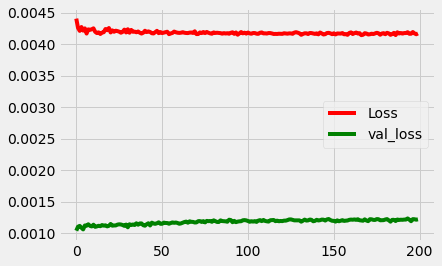

In [41]:
plt.plot(historico.history['loss'],'r',label="Loss")
plt.plot(historico.history['val_loss'],'g',label="val_loss")
plt.legend()

In [42]:
y_pred = regressor.predict(x_test_3D)

In [44]:
y_pred_inverse_norm = sc.inverse_transform(y_pred)
print("pred",y_pred_inverse_norm)
y_revenue_test = y_revenue_test.reshape(-1,1)

y_revenue_test_inverse_norm = sc.inverse_transform(y_revenue_test)

print("real",y_revenue_test_inverse_norm)

print(np.sum(np.abs(y_revenue_test_inverse_norm-y_pred_inverse_norm))/y_pred_inverse_norm.shape[0])

pred [[1992.3289]
 [2010.0665]
 [2001.8981]
 [2007.395 ]
 [1970.6711]
 [1952.4758]
 [2005.6488]
 [2014.6814]
 [1976.561 ]
 [1946.5288]
 [1965.7716]
 [1957.4985]
 [1950.1842]
 [1954.3977]
 [1960.072 ]
 [1966.8044]
 [1971.5548]
 [1974.324 ]
 [1953.2938]
 [1949.7296]
 [1958.2006]]
real [[1775.26890007]
 [1412.57397632]
 [1667.51747946]
 [1563.99786996]
 [1489.23805543]
 [1621.93098471]
 [1869.09646243]
 [1706.70698489]
 [1302.71308372]
 [1797.68435324]
 [1675.14615751]
 [1728.67437883]
 [2976.91742212]
 [2275.2564133 ]
 [2052.43900201]
 [1529.35387007]
 [1643.68755961]
 [1458.97012528]
 [1504.74733356]
 [1765.63123314]
 [1959.59041004]]
359.31629746914103
